In [37]:
import numpy as np
from matplotlib import pyplot as plt
import utils_hugo as ut
from importlib import reload
plt.style.use('default')
reload(ut);

# Loading the data

In [38]:
n_samples = 100
seed=0

In [39]:
bids_dir = "/Users/hugofluhr/DATA/ds003505/"
#subjects = ['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10', 'sub-11', ]
subjects = ['sub-{:02d}'.format(i) for i in range(1,21) if i!=5]
epochs_multi, y_multi = ut.multiple_subjects_epochs(bids_dir=bids_dir, subjects= subjects, tmin=-0.1, tmax=0.5, apply_proj=False, apply_baseline=True)
X_red, y_red, S_red = ut.aggregate_epochs(epochs_multi,y_multi, subjects)
del epochs_multi, y_multi
#X_red, y_red, S_red = ut.reduce_trials(X, y, S, n_samples=n_samples, seed=seed)
#del X, y, S

In [40]:
X_red.shape

(10983, 128, 151)

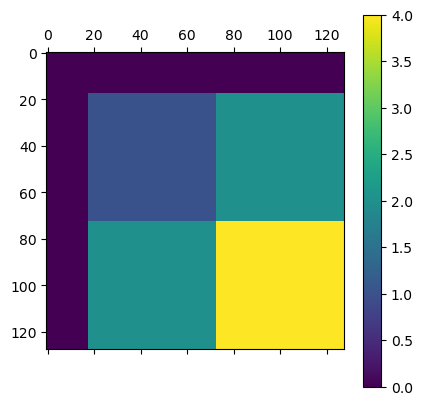

In [41]:
node_order, hemi = ut.get_node_ordering(with_hemi=True)
# use A[np.ix_(node_order, node_order)]  
mask = np.outer(hemi,hemi)
plt.matshow(mask)
plt.colorbar()

In [42]:
np.unique(mask)

array([0, 1, 2, 4])

# Compute Adjacencies

In [43]:
A = ut.compute_graphs_multi(X_red, ut.corr_coef_graph, threshold=False)
del X_red

  0%|          | 0/10983 [00:00<?, ?it/s]

In [44]:
A.shape

(10983, 128, 128)

# Graph characterization

- number of nodes and edges/density
- degree distribution (+ moments?)
- path matrices not informative
- diameter
- CC
- assignment 1b : simulate network models to compare to

## Example graphs and variation between subjects and trial types

1


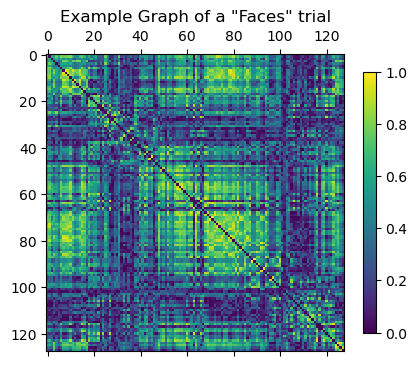

In [45]:
# example graph for Faces trial
a = A[0]
print(y_red[0])
plt.matshow(a[np.ix_(node_order, node_order)][np.ix_(node_order, node_order)], vmax=1)
plt.title('Example Graph of a "Faces" trial')
plt.colorbar(shrink=.7)
plt.show()

0


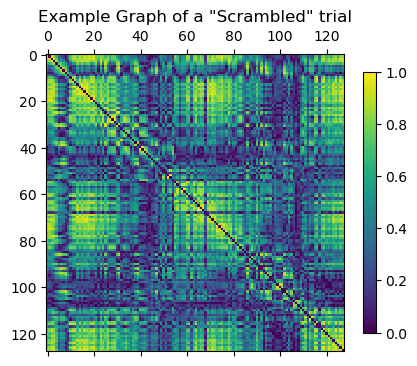

In [46]:
# example graph for Scrambled trial
ind = 2
print(y_red[ind])
plt.matshow(A[ind][np.ix_(node_order, node_order)], vmax=1)
plt.title('Example Graph of a "Scrambled" trial')
plt.colorbar(shrink=.7)
plt.show()

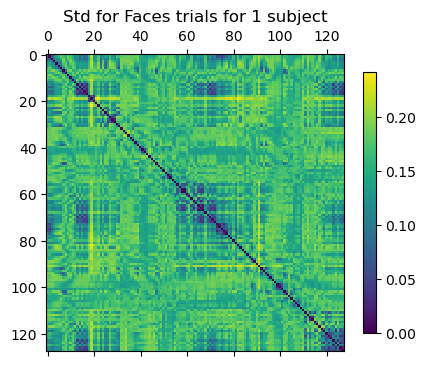

In [47]:
ind = np.logical_and(y_red==1, S_red=='sub-01')
plt.matshow(A[ind].std(axis=0)[np.ix_(node_order, node_order)])
plt.title('Std for Faces trials for 1 subject')
plt.colorbar(shrink=.7)
plt.show()

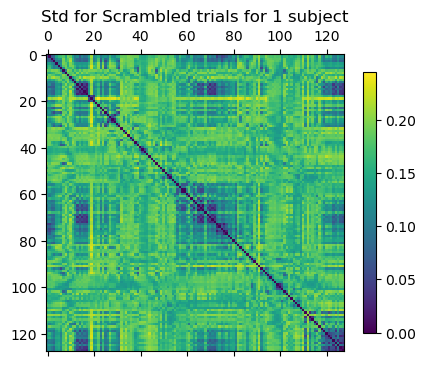

In [48]:
ind = np.logical_and(y_red==0, S_red=='sub-01')
plt.matshow(A[ind].std(axis=0)[np.ix_(node_order, node_order)])
plt.title('Std for Scrambled trials for 1 subject')
plt.colorbar(shrink=.7)
plt.show()

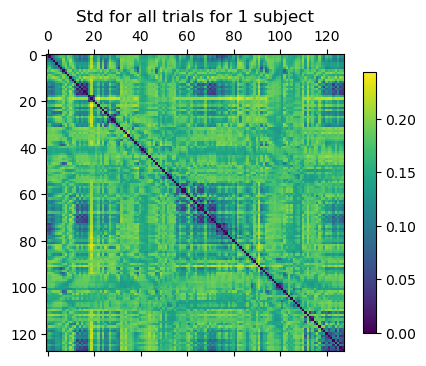

In [49]:
ind = S_red=='sub-01'
plt.matshow(A[ind].std(axis=0)[np.ix_(node_order, node_order)])
plt.title('Std for all trials for 1 subject')
plt.colorbar(shrink=.7)
plt.show()

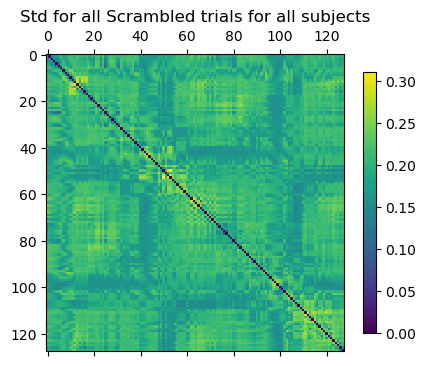

In [50]:
ind = y_red==0
plt.matshow(A[ind].std(axis=0)[np.ix_(node_order, node_order)])
plt.title('Std for all Scrambled trials for all subjects')
plt.colorbar(shrink=.7)
plt.show()

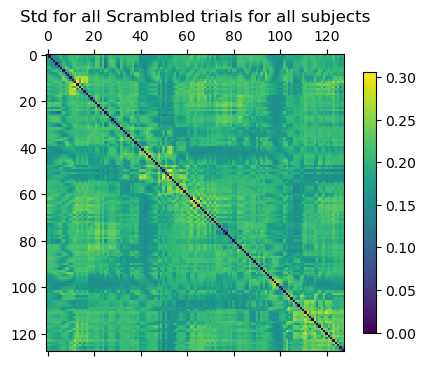

In [51]:
ind = y_red==1
plt.matshow(A[ind].std(axis=0)[np.ix_(node_order, node_order)])
plt.title('Std for all Scrambled trials for all subjects')
plt.colorbar(shrink=.7)
plt.show()

In [52]:
reload(ut)
#dist_matrix = ut.electrode_distances()
dist_geodesic = ut.electrode_distances_geodesic()
#dist_x = ut.electrode_x_distances()

## Edge weight vs electrode distance

Text(0.5, 0, 'electrode geodesic distance')

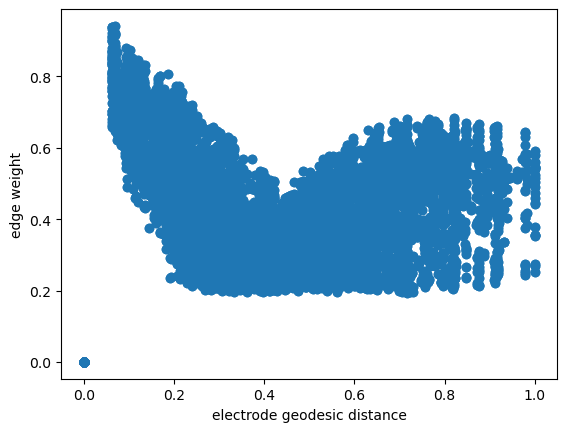

In [53]:
plt.scatter(dist_geodesic.flatten(), A.mean(axis=0).flatten())
plt.ylabel('edge weight')
plt.xlabel('electrode geodesic distance')

In [54]:
A_thresh = ut.threshold_graphs(A, 0.2)

Text(0.5, 0, 'electrode geodesic distance')

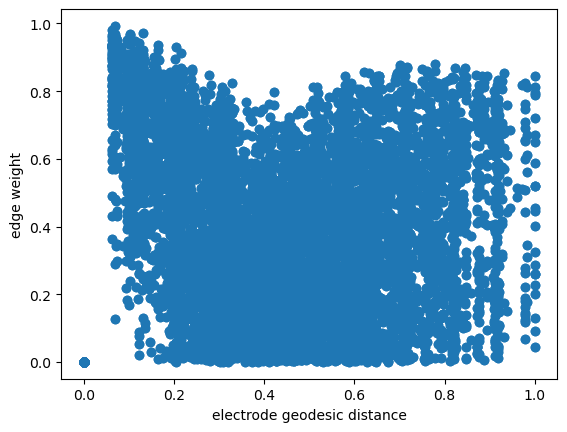

In [55]:
plt.scatter(dist_geodesic.flatten(), A[0].flatten())
plt.ylabel('edge weight')
plt.xlabel('electrode geodesic distance')

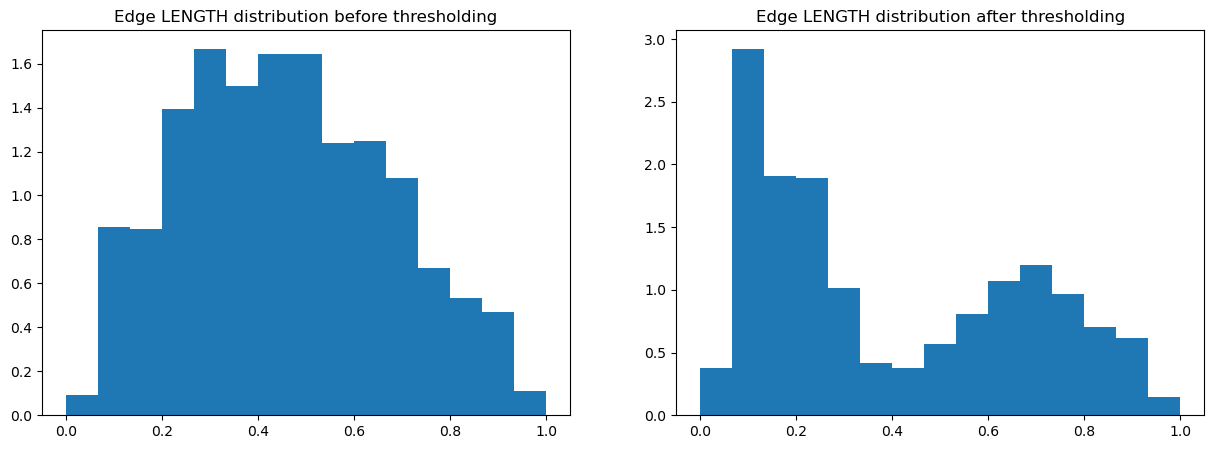

In [56]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].hist(dist_geodesic.flatten(), weights=A.astype(bool).sum(axis=0).flatten(), bins=15,density=True)
axs[0].set_title('Edge LENGTH distribution before thresholding')
axs[1].hist(dist_geodesic.flatten(), weights=A_thresh.astype(bool).sum(axis=0).flatten(), bins=15,density=True)
axs[1].set_title('Edge LENGTH distribution after thresholding')

plt.show()

Text(0.5, 0, 'electrode geodesic distance')

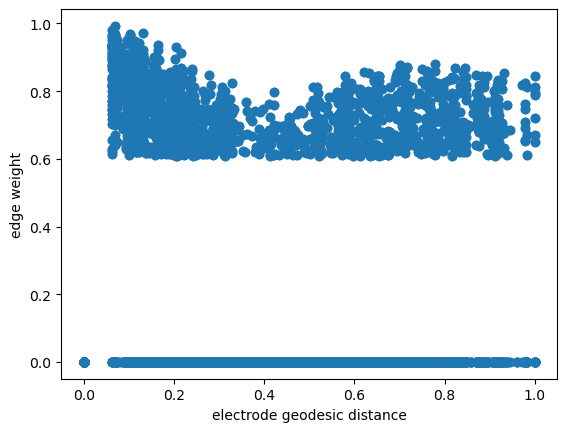

In [57]:
plt.scatter(dist_geodesic.flatten(), A_thresh[0].flatten())
plt.ylabel('edge weight')
plt.xlabel('electrode geodesic distance')

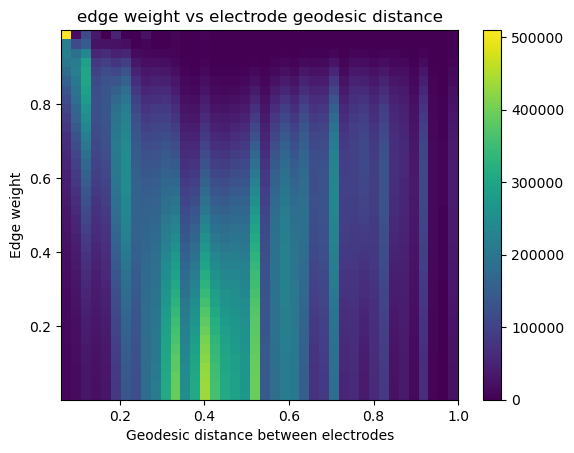

In [100]:
dist_flat = np.broadcast_to(dist_geodesic, A.shape).flatten()
plt.hist2d(dist_flat[dist_flat>0], A.flatten()[A.flatten()>0],bins=40)#, vmax=60000)
plt.colorbar()
plt.xlabel('Geodesic distance between electrodes')
plt.ylabel('Edge weight')
plt.title('edge weight vs electrode geodesic distance')
plt.show()

## Reordered nodes

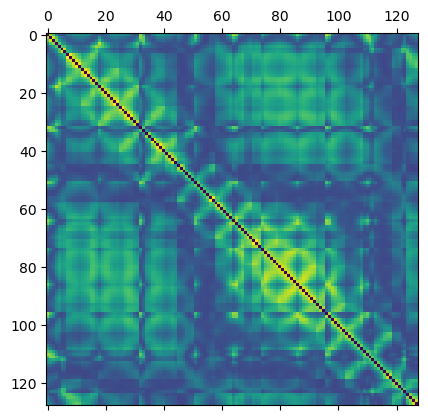

In [59]:
plt.matshow(A.mean(axis=0))

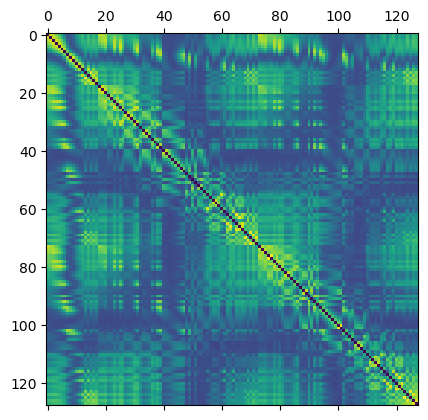

In [60]:
plt.matshow(A.mean(axis=0)[np.ix_(node_order, node_order)])

## Take binary thresholded graph

In [61]:
A_thresh.shape

(10983, 128, 128)

In [62]:
A_bin = A_thresh.copy()
A_bin[A_bin!=0] = 1.
A_bin.shape

(10983, 128, 128)

In [63]:
# count cases of disconnected nodes
disc_graph_counts = 0
disc_nodes_counts = 0
for a in A_bin :
    d = a.sum(axis=0)
    disc_nodes_counts+=np.sum(d==0)
    disc_graph_counts+=np.any(d==0)

In [64]:
disc_graph_counts

9285

In [65]:
disc_nodes_counts

48268

## Create Consensus Graph

In [66]:
def compute_consensus_graph(adjs_bin, density=.2):
    consensus = adjs_bin.sum(axis=0)
    threshold = ut.calculate_threshold(consensus, density)
    consensus[consensus<threshold]=0
    consensus[consensus!=0]=1
    return consensus

In [67]:
Concensus = compute_consensus_graph(A_bin)
Concensus.shape

(128, 128)

## Degree Distribution

In [68]:
D = A_bin.sum(axis=-1)
D.shape

(10983, 128)

In [69]:
D_con = Concensus.sum(axis=-1)
D_con.shape

(128,)

Text(0.5, 1.0, 'Degree Distribution of Consensus Graph')

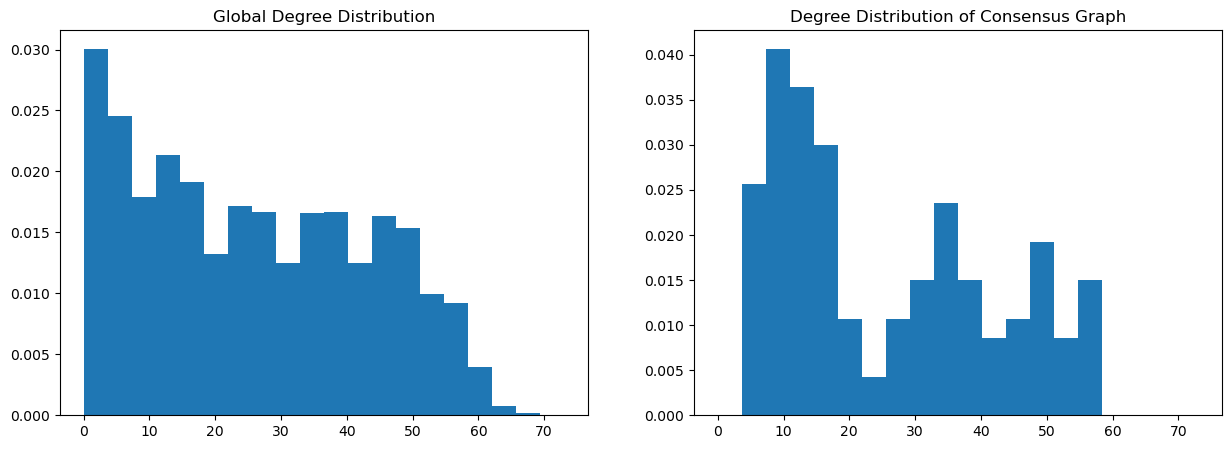

In [70]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
out1 = axs[0].hist(D.flatten(),bins=20,density=True)
axs[0].set_title('Global Degree Distribution')
axs[1].hist(D_con, bins=out1[1],density=True)
axs[1].set_title('Degree Distribution of Consensus Graph')

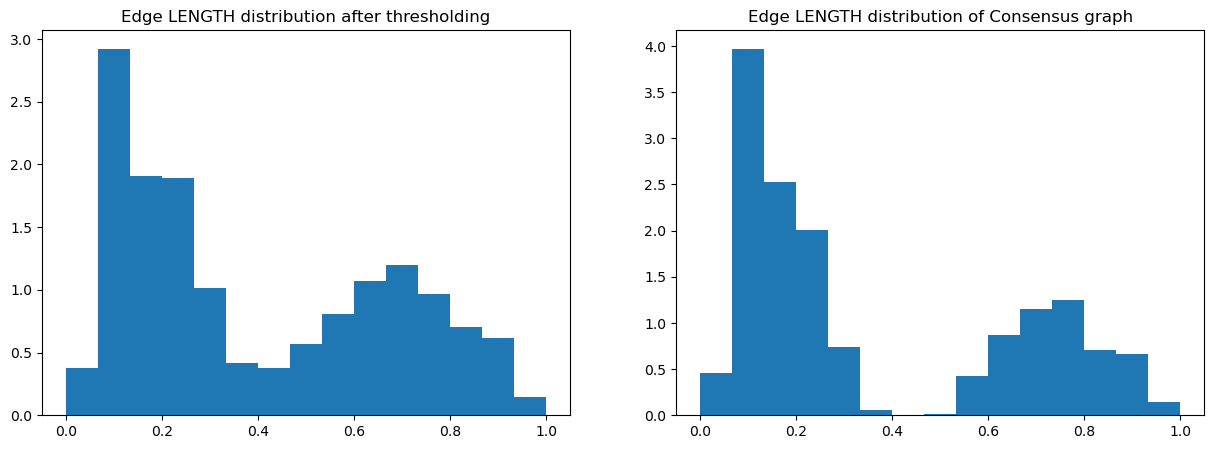

In [71]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].hist(dist_geodesic.flatten(), weights=A_bin.sum(axis=0).flatten(), bins=15,density=True)
axs[0].set_title('Edge LENGTH distribution after thresholding')
axs[1].hist(dist_geodesic.flatten(), weights=Concensus.flatten(), bins=15,density=True)
axs[1].set_title('Edge LENGTH distribution of Consensus graph')

plt.show()

### Fitting Curves to degree distribution

In [72]:
from scipy.stats import poisson
from scipy.optimize import curve_fit
import warnings

warnings.filterwarnings('ignore')

# Sample degree distribution data
degrees = D.flatten()
N = len(degrees)

# Calculate the degree frequencies
unique_degrees, degree_counts = np.unique(degrees, return_counts=True)

# Normalize the degree distribution
#degree_probs = degree_counts / np.sum(degree_counts)
degree_probs = degree_counts

# Define the Poisson distribution function
def poisson_distribution(k, lambd):
    return N*poisson.pmf(k, lambd)

# my power law
def func_powerlaw(x, m, c, c0):
    return c0 + x**m * c

# exp law
def func_explaw(x, m, t, b):
    return m * np.exp(-t * x) + b

# Fit the Poisson distribution to the degree distribution
params, _ = curve_fit(poisson_distribution, unique_degrees, degree_probs)

# Fit the power law distribution to the degree distribution
powerlaw_params, _ = curve_fit(func_powerlaw, unique_degrees, degree_probs)

# Fit the exponential law distribution to the degree distribution
explaw_params, _ = curve_fit(func_explaw, unique_degrees, degree_probs, maxfev=20000)

# Generate x-values for the fitted Poisson and power law distribution curves
#x_values = np.arange(min(unique_degrees), max(unique_degrees) + 1)
x_values = np.arange(0, max(unique_degrees) + 1)

# Calculate the corresponding y-values using the fitted parameters
poisson_y_values = poisson_distribution(x_values, np.mean(degrees))
powerlaw_y_values = func_powerlaw(x_values, *powerlaw_params)
explaw_y_values = func_explaw(x_values, *explaw_params)

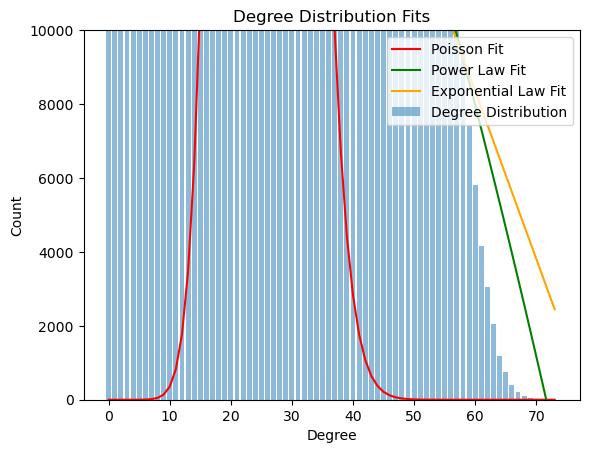

In [73]:

# Plot the original degree distribution and the fitted Poisson and power law distributions
plt.bar(unique_degrees, degree_probs, label='Degree Distribution', alpha=.5)
plt.plot(x_values, poisson_y_values, 'r-', label='Poisson Fit')
plt.plot(x_values, powerlaw_y_values, 'g-', label='Power Law Fit')
plt.plot(x_values, explaw_y_values, c='orange', label='Exponential Law Fit')

plt.ylim([0,10000])
plt.xlabel('Degree')
plt.ylabel('Count')

plt.title('Degree Distribution Fits')
plt.legend()
plt.show()


## Create Model Graphs to compare to

In [74]:
import networkx as  nx

### Check Giant Component

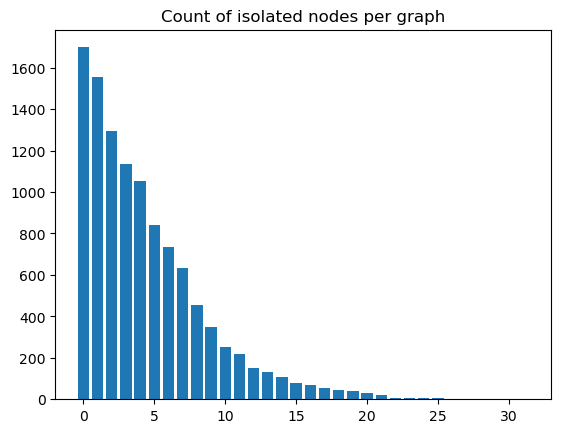

In [75]:
# Count proportion of graphs containing isolated nodes
unique_isol, isol_counts = np.unique(np.sum(D==0, axis=1), return_counts=True)
plt.bar(unique_isol, isol_counts)
plt.title('Count of isolated nodes per graph')
plt.show()

In [76]:
GC_n_nodes = []
for adj in A_bin :
    G = nx.from_numpy_array(adj)
    GC_n_nodes.append(len(max(nx.connected_components(G), key=len)))
GC_n_nodes= np.array(GC_n_nodes)

In [77]:
GC_n_nodes.mean()

121.97933169443685

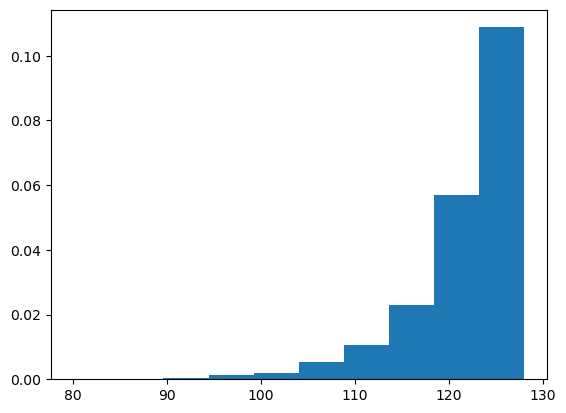

In [78]:
plt.hist(GC_n_nodes, density=True)
plt.show()

In [79]:
N_graphs = A_bin.shape[0]
N = A_bin.shape[1]
M = int(np.mean(A_bin.sum(axis=(1,2)))/2)
print("Number of links in each graph : {}".format(M))

Number of links in each graph : 1639


### Properties of our graphs

In [81]:
# We want the average clustering coeff and distance and diameter of our graphs
from multiprocessing import Pool
from tqdm.notebook import tqdm
CCs, SPLs, Diams = [], [], []
with Pool() as pool:
    for cc, spl, diam in tqdm(pool.map(ut.compute_graph_stats, A_bin), total=len(A_bin)):
        CCs.append(cc)
        SPLs.append(spl)
        Diams.append(diam)

  0%|          | 0/10983 [00:00<?, ?it/s]

In [82]:
print('Clustering Coeff : mean={:.2f}, std={:.2f}'.format(np.mean(CCs), np.std(CCs)))
print('Avg SPL : mean={:.2f}, std={:.2f}'.format(np.mean(SPLs), np.std(SPLs)))
print('Diameter : mean={:.2f}, std={:.2f}'.format(np.mean(Diams), np.std(Diams)))


Clustering Coeff : mean=0.62, std=0.03
Avg SPL : mean=2.27, std=0.16
Diameter : mean=6.22, std=1.47


In [83]:
# Erdos Renyi
p_er = 2*M/(N*(N-1))

G_er = nx.erdos_renyi_graph(N, p_er, seed=seed)

In [84]:
# Watts-Strogatz
k_ws = np.round(2*M/N).astype(int)
p_ws = .01 # found using method in assigmnent 1b 

G_ws = nx.watts_strogatz_graph(N, k_ws, p_ws, seed=seed)

In [85]:
# Barabasi Albert
q_ba = round(M/N)

G_ba = nx.barabasi_albert_graph(N, q_ba)

In [86]:
for model, graph in zip(['ER','WS','BA'],[G_er, G_ws, G_ba]):
    print('Model : {}'.format(model))
    print(ut.compute_graph_stats(nx.to_numpy_array(graph)))


Model : ER
(0.19575324123876453, 1.8065944881889764, 3)
Model : WS
(0.6918205401935017, 2.283464566929134, 4)
Model : BA
(0.29498805289546026, 1.8357529527559056, 3)


(array([ 794., 3179., 3104., 2023., 1047.,  504.,  209.,   78.,   31.,
          14.]),
 array([ 3. ,  4.1,  5.2,  6.3,  7.4,  8.5,  9.6, 10.7, 11.8, 12.9, 14. ]),
 <BarContainer object of 10 artists>)

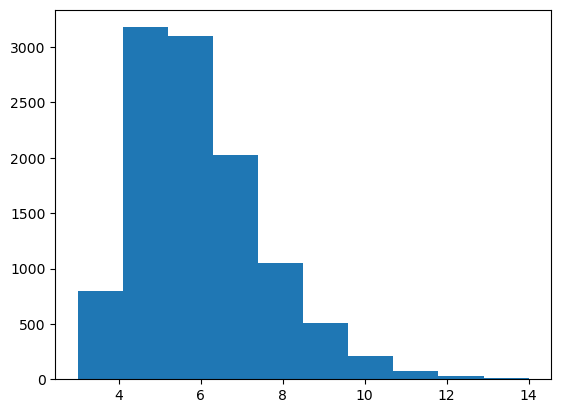

In [88]:
plt.hist(Diams)

# GSP

In [92]:
Concensus

array([[0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 1., 0.]])

In [93]:
import pygsp
from plotly import express as px
import pandas as pd

In [94]:
adj_struct = np.load('/Users/hugofluhr/Documents/Cours/NML/NetworkMachineLearning_2023/utils/electrodes_adj.npy')

In [95]:
G_cons = pygsp.graphs.Graph(A_thresh.mean(axis=0), lap_type='normalized')
G_cons.compute_fourier_basis()

In [96]:
fname = '../EEGDataset/electrode_coordinates.csv'
df = pd.read_csv(fname)

In [99]:
px.scatter_3d(df, x='x',y='y',z='z', color=G_cons.U[:,1])